<a href="https://colab.research.google.com/github/binodmathews93/GUVI-DeepLearning/blob/main/Initialization_and_Activation_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

## Generate data

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


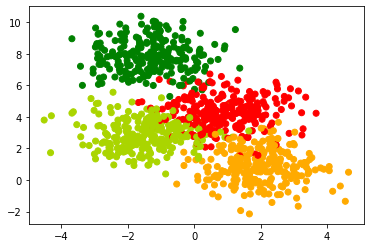

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

## Multi class classification

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [8]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


## FF Class

In [12]:
class FFNetwork:
  
  def __init__(self, init_method = 'random', activation_function = 'sigmoid', leaky_slope = 0.1):
        
    self.params={}
    self.params_h = []
    self.num_layers=2
    self.layer_sizes = [2, 2, 4]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    
    np.random.seed(0)
    
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "zeros":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.zeros((self.layer_sizes[i-1],self.layer_sizes[i]))
        self.params["B"+str(i)]=np.zeros((1,self.layer_sizes[i]))
    
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = {}
      Y_pred = self.predict(X)
      loss[0] = log_loss(np.argmax(Y, axis=1), Y_pred)

    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
          
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch+1] = log_loss(np.argmax(Y, axis=1), Y_pred)
        self.params_h.append(np.concatenate((self.params['W1'].ravel(), self.params['W2'].ravel(), self.params['B1'].ravel(), self.params['B2'].ravel())))
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [13]:
def post_process(scatter_plot=False, gradient_plot=True, plot_scale=0.1):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))    
    
    if scatter_plot:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()
      
    if gradient_plot:
      h = np.asarray(model.params_h)
      h_diff = (h[0:-1, :] - h[1:, :])
      for i in range(18):
        plt.subplot(6, 3, i+1)
        plt.plot(h_diff[:, i], '-')
        plt.ylim((-plot_scale, plot_scale))
        plt.yticks([])
        plt.xticks([])
      plt.show()

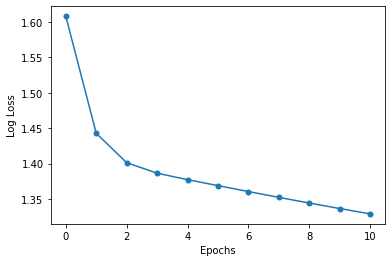

Training accuracy 0.376
Validation accuracy 0.384


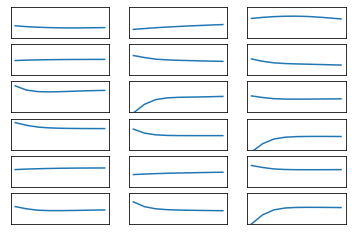

In [14]:
model = FFNetwork(init_method='xavier', activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=10, eta=1, algo="GD", display_loss=True)
post_process()

zeros sigmoid


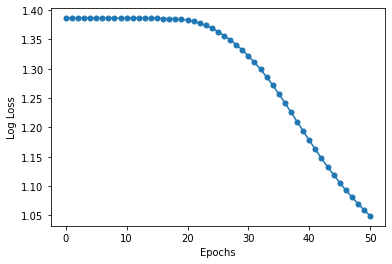

Training accuracy 0.528
Validation accuracy 0.54


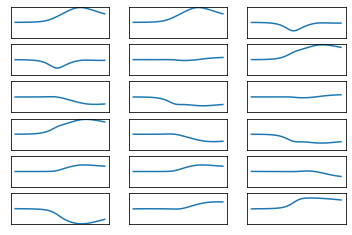


--

random sigmoid


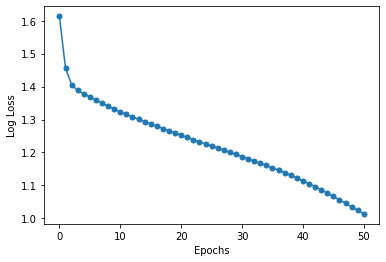

Training accuracy 0.5827
Validation accuracy 0.568


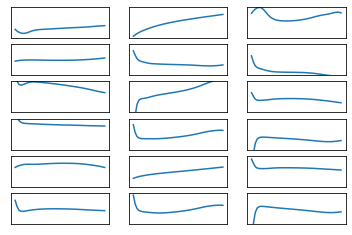


--

xavier sigmoid


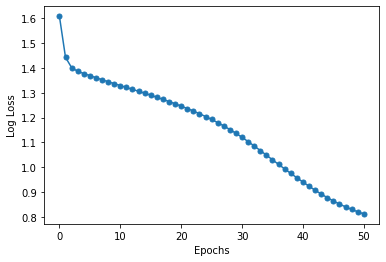

Training accuracy 0.8747
Validation accuracy 0.88


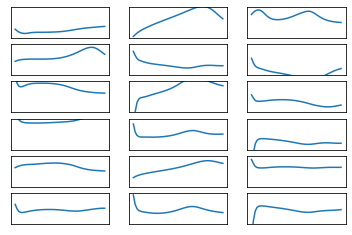


--

he sigmoid


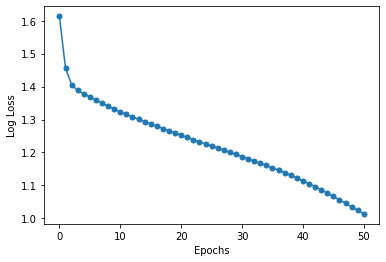

Training accuracy 0.5827
Validation accuracy 0.568


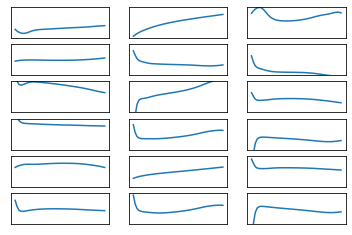


--



In [15]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['sigmoid']:
    print(init_method, activation_function)
    model = FFNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=50, eta=1, algo="GD", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

zeros tanh


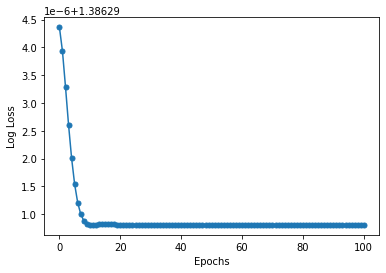

Training accuracy 0.2507
Validation accuracy 0.248


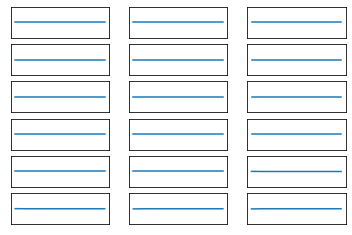


--

random tanh


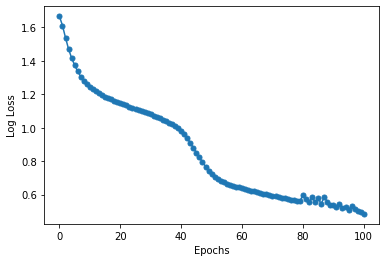

Training accuracy 0.8547
Validation accuracy 0.86


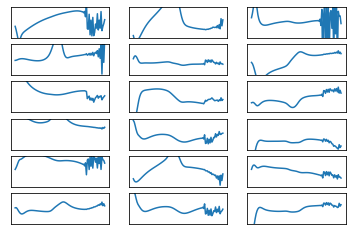


--

xavier tanh


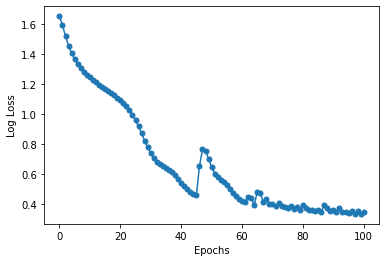

Training accuracy 0.88
Validation accuracy 0.88


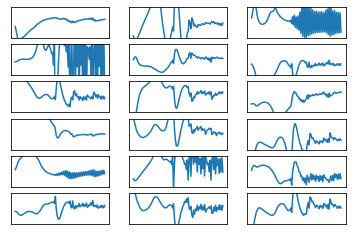


--

he tanh


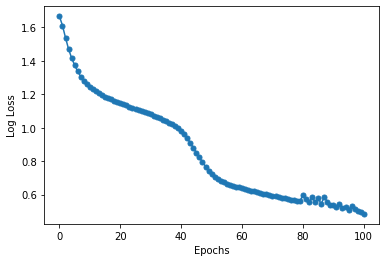

Training accuracy 0.8547
Validation accuracy 0.86


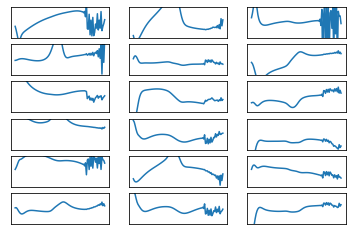


--



In [16]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['tanh']:
    print(init_method, activation_function)
    model = FFNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=100, eta=0.5, algo="NAG", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

zeros relu


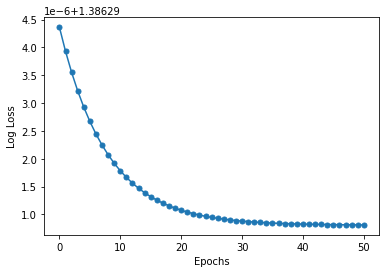

Training accuracy 0.2507
Validation accuracy 0.248


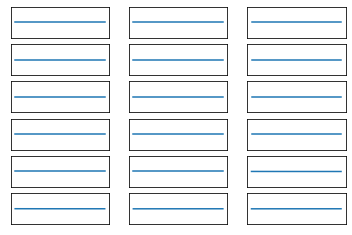


--

random relu


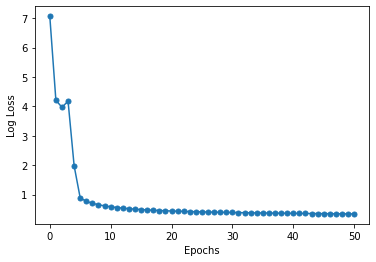

Training accuracy 0.9067
Validation accuracy 0.92


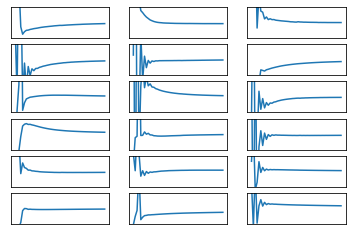


--

xavier relu


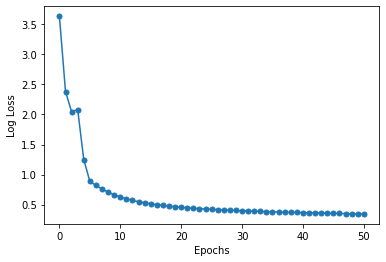

Training accuracy 0.9053
Validation accuracy 0.924


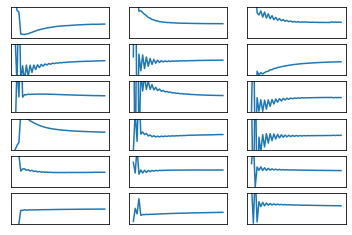


--

he relu


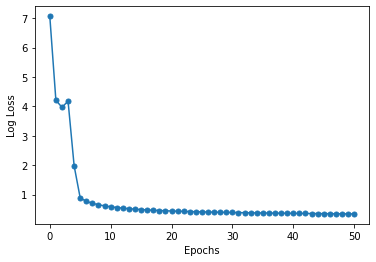

Training accuracy 0.9067
Validation accuracy 0.92


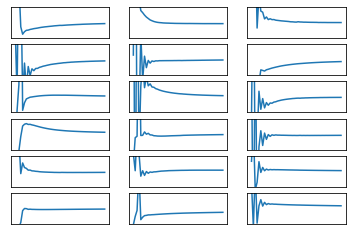


--



In [17]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['relu']:
    print(init_method, activation_function)
    model = FFNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=50, eta=0.25, algo="GD", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

zeros leaky_relu


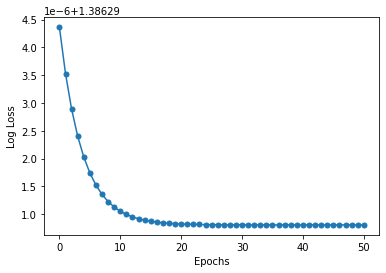

Training accuracy 0.2507
Validation accuracy 0.248


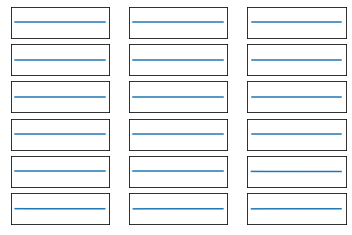


--

random leaky_relu


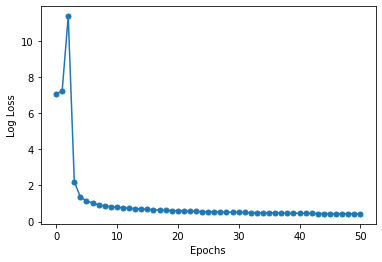

Training accuracy 0.8933
Validation accuracy 0.9


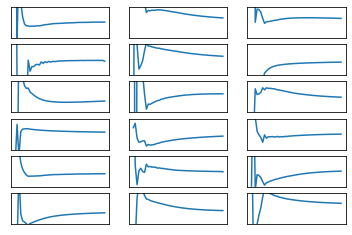


--

xavier leaky_relu


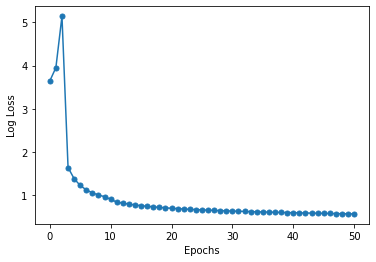

Training accuracy 0.8027
Validation accuracy 0.812


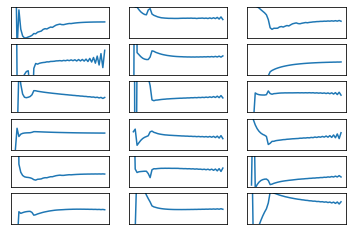


--

he leaky_relu


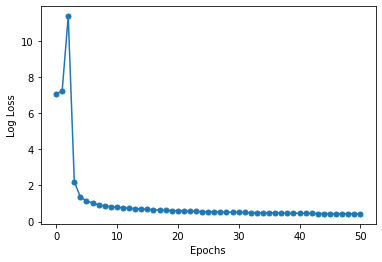

Training accuracy 0.8933
Validation accuracy 0.9


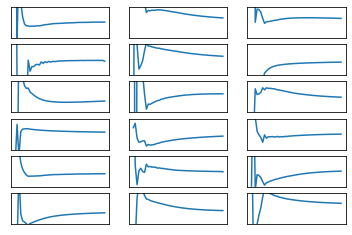


--



In [18]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['leaky_relu']:
    print(init_method, activation_function)
    model = FFNetwork(init_method=init_method, activation_function=activation_function, leaky_slope=0.1)
    model.fit(X_train, y_OH_train, epochs=50, eta=0.5, algo="GD", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

## Exercises

1. Try out different combinations of learning_algorithm, initialisation method, and activation_function
2. Try a deeper network - eg. [2, 2, 2, 4] 
3. Try a different dataset, i.e. different set of blobs

Momentum zeros tanh


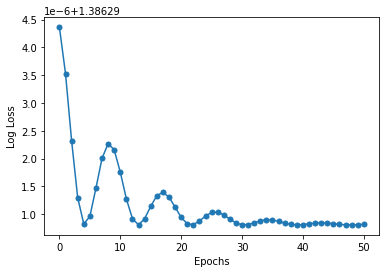

Training accuracy 0.2507
Validation accuracy 0.248


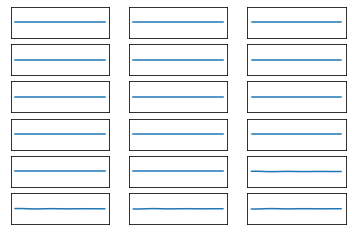


--

Momentum random tanh


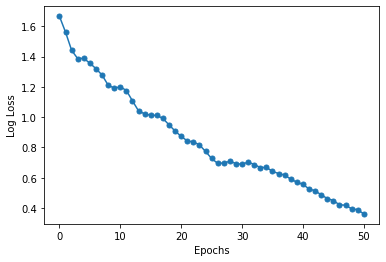

Training accuracy 0.8707
Validation accuracy 0.88


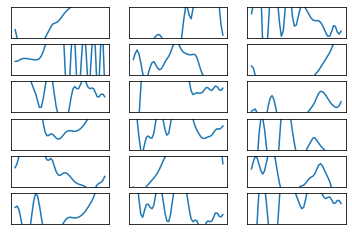


--

Momentum xavier tanh


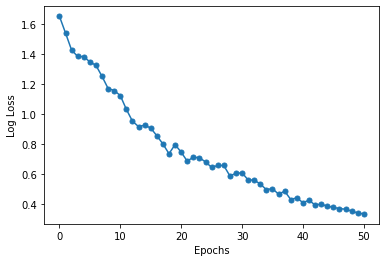

Training accuracy 0.872
Validation accuracy 0.88


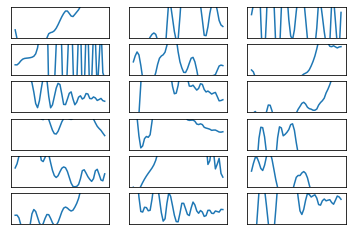


--

Momentum he tanh


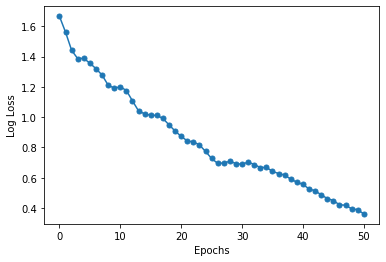

Training accuracy 0.8707
Validation accuracy 0.88


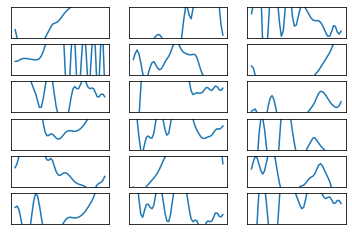


--

NAG zeros tanh


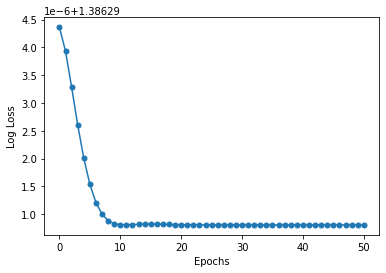

Training accuracy 0.2507
Validation accuracy 0.248


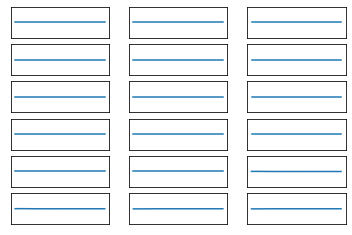


--

NAG random tanh


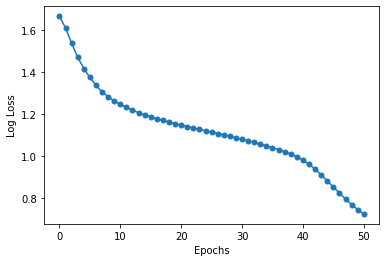

Training accuracy 0.6867
Validation accuracy 0.664


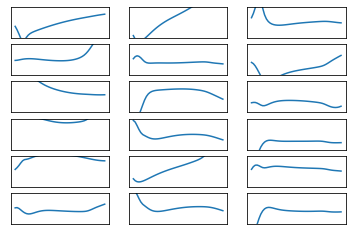


--

NAG xavier tanh


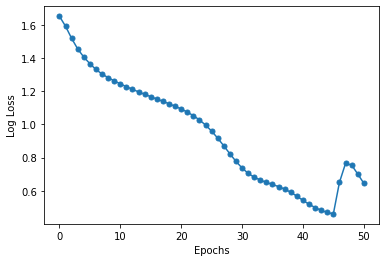

Training accuracy 0.7
Validation accuracy 0.704


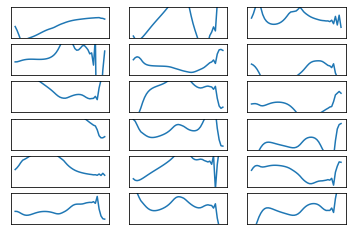


--

NAG he tanh


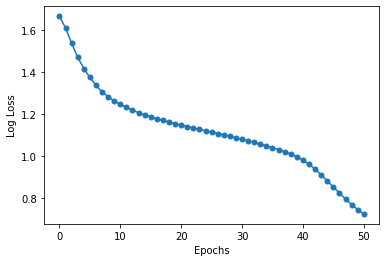

Training accuracy 0.6867
Validation accuracy 0.664


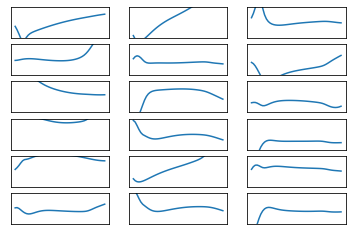


--

AdaGrad zeros tanh


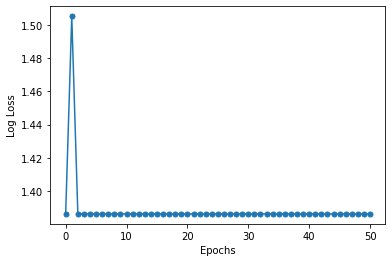

Training accuracy 0.2507
Validation accuracy 0.248


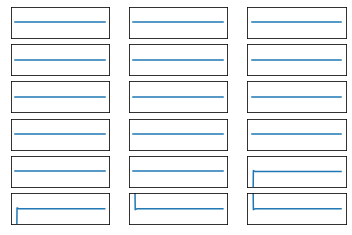


--

AdaGrad random tanh


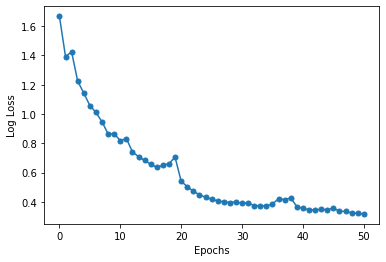

Training accuracy 0.8933
Validation accuracy 0.892


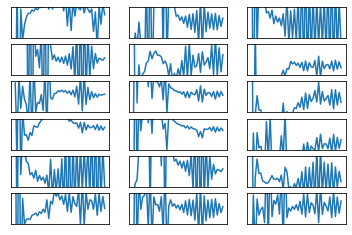


--

AdaGrad xavier tanh


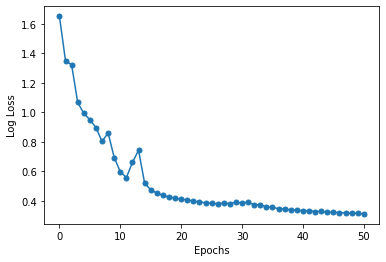

Training accuracy 0.8933
Validation accuracy 0.896


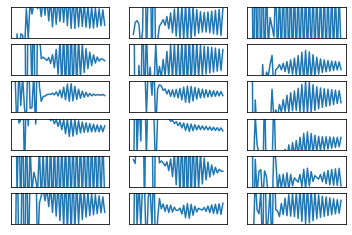


--

AdaGrad he tanh


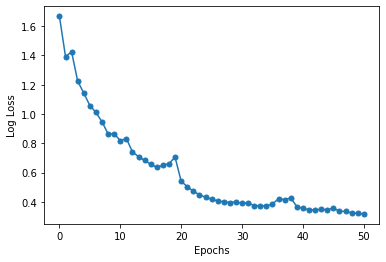

Training accuracy 0.8933
Validation accuracy 0.892


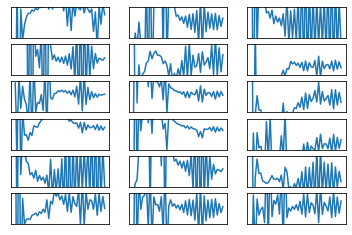


--

RMSProp zeros tanh


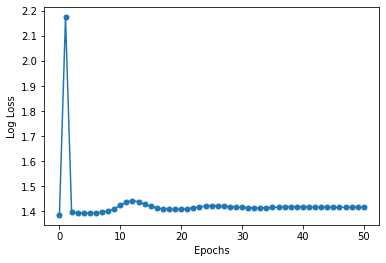

Training accuracy 0.2493
Validation accuracy 0.252


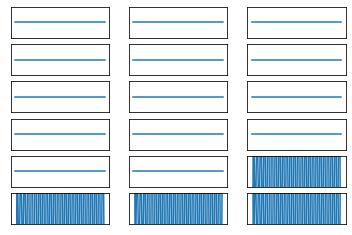


--

RMSProp random tanh


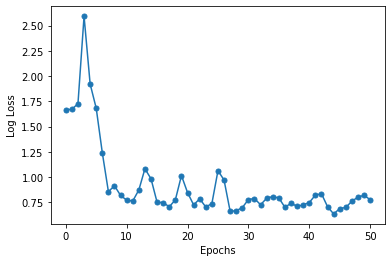

Training accuracy 0.684
Validation accuracy 0.692


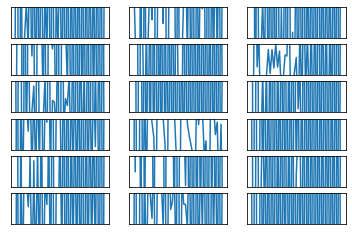


--

RMSProp xavier tanh


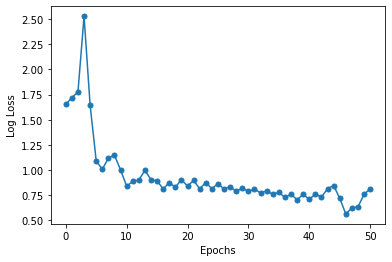

Training accuracy 0.6107
Validation accuracy 0.612


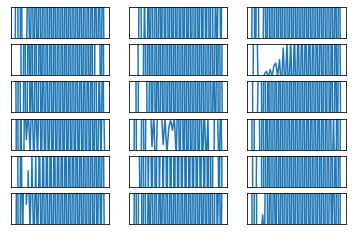


--

RMSProp he tanh


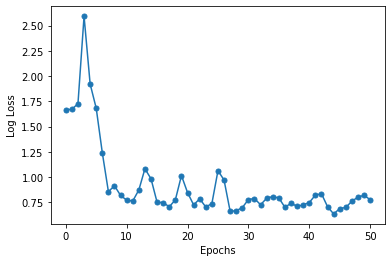

Training accuracy 0.684
Validation accuracy 0.692


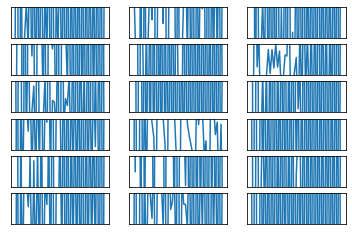


--

Adam zeros tanh


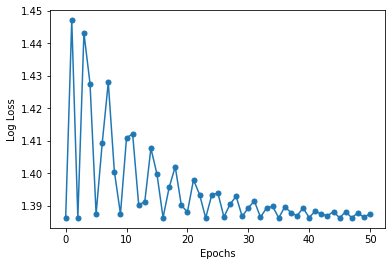

Training accuracy 0.2493
Validation accuracy 0.252


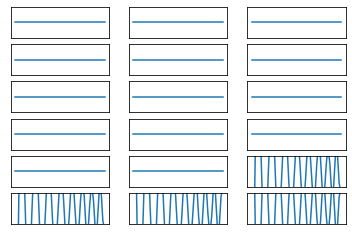


--

Adam random tanh


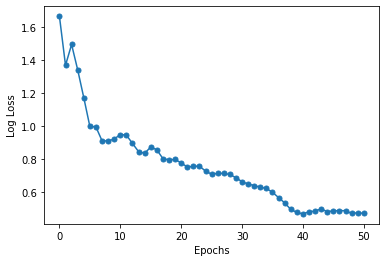

Training accuracy 0.824
Validation accuracy 0.816


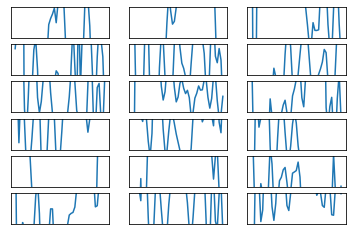


--

Adam xavier tanh


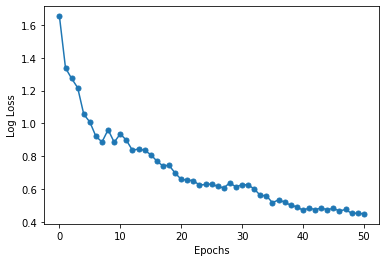

Training accuracy 0.8347
Validation accuracy 0.824


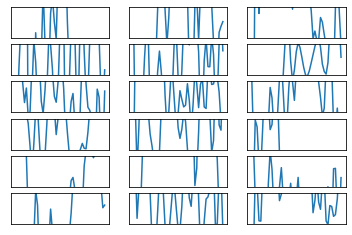


--

Adam he tanh


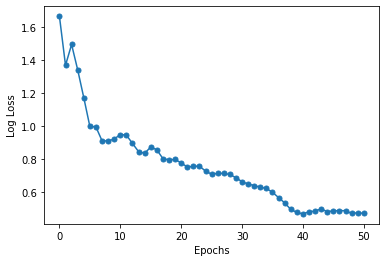

Training accuracy 0.824
Validation accuracy 0.816


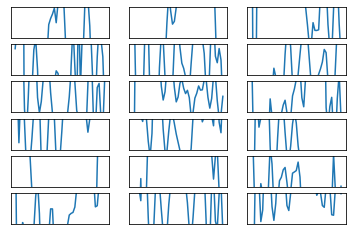


--



In [22]:
for algo in ['Momentum', 'NAG', 'AdaGrad', 'RMSProp', 'Adam']:
  for init_method in ['zeros', 'random', 'xavier', 'he']:
    for activation_function in ['tanh']:
      print(algo, init_method, activation_function)
      model = FFNetwork(init_method=init_method, activation_function=activation_function, leaky_slope=0.1)
      model.fit(X_train, y_OH_train, epochs=50, eta=0.5, algo=algo, display_loss=True)
      post_process(plot_scale=0.05)
      print('\n--\n')

Momentum zeros leaky_relu


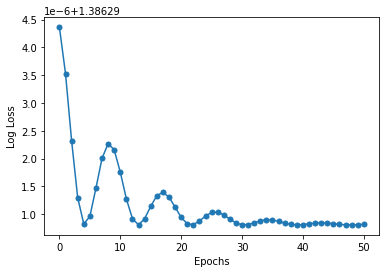

Training accuracy 0.2507
Validation accuracy 0.248


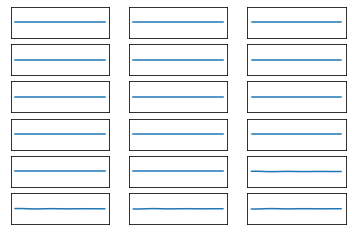


--

Momentum random leaky_relu


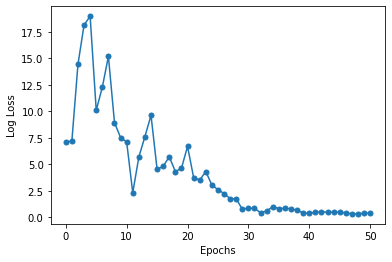

Training accuracy 0.8933
Validation accuracy 0.908


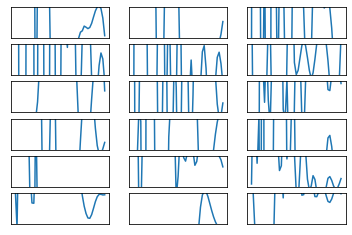


--

Momentum xavier leaky_relu


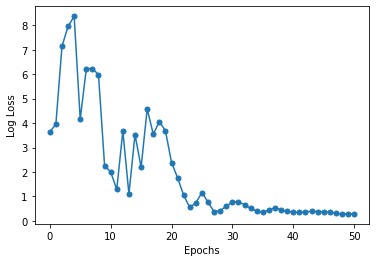

Training accuracy 0.9107
Validation accuracy 0.912


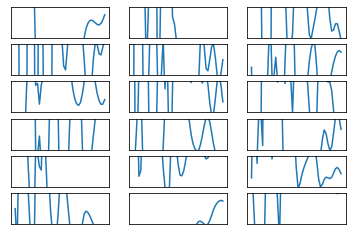


--

Momentum he leaky_relu


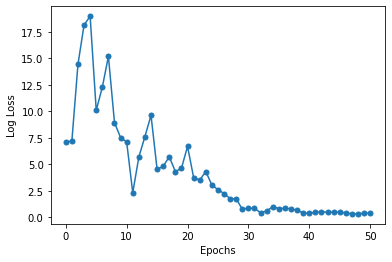

Training accuracy 0.8933
Validation accuracy 0.908


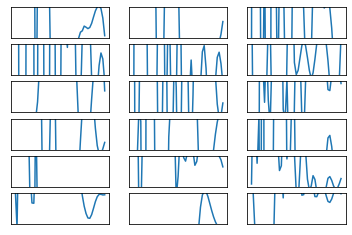


--

NAG zeros leaky_relu


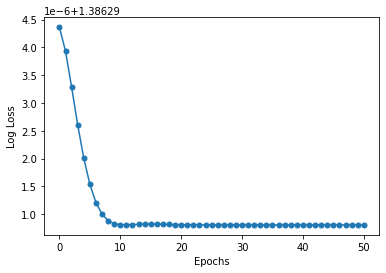

Training accuracy 0.2507
Validation accuracy 0.248


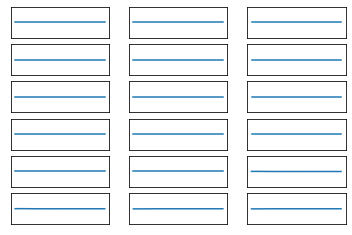


--

NAG random leaky_relu


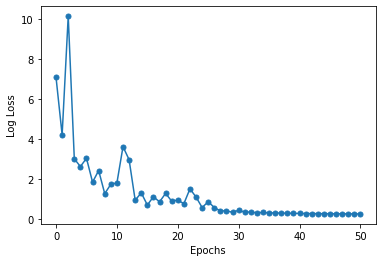

Training accuracy 0.9213
Validation accuracy 0.936


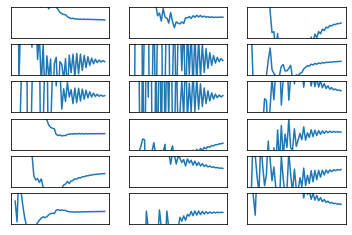


--

NAG xavier leaky_relu


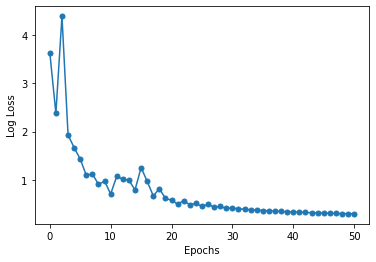

Training accuracy 0.9253
Validation accuracy 0.948


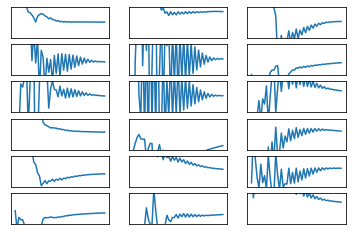


--

NAG he leaky_relu


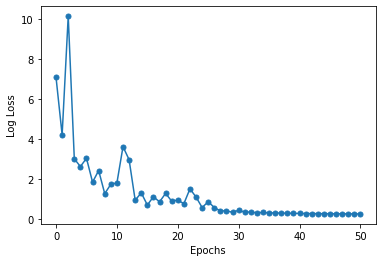

Training accuracy 0.9213
Validation accuracy 0.936


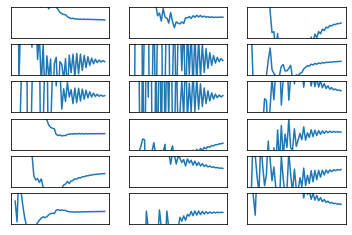


--

AdaGrad zeros leaky_relu


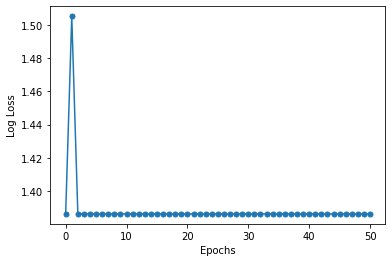

Training accuracy 0.2507
Validation accuracy 0.248


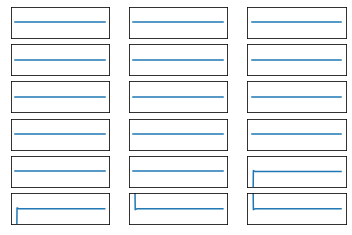


--

AdaGrad random leaky_relu


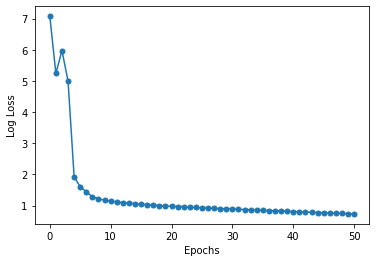

Training accuracy 0.7533
Validation accuracy 0.736


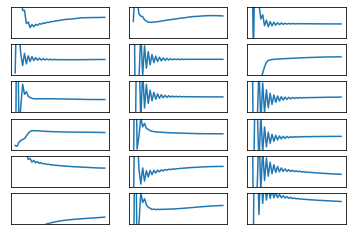


--

AdaGrad xavier leaky_relu


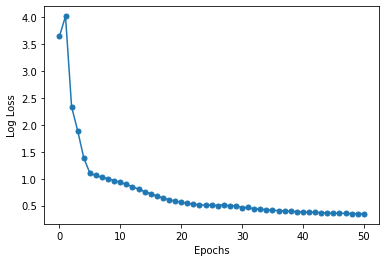

Training accuracy 0.896
Validation accuracy 0.928


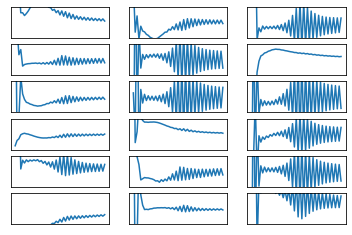


--

AdaGrad he leaky_relu


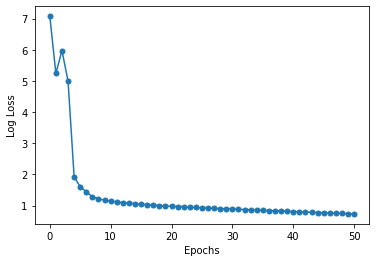

Training accuracy 0.7533
Validation accuracy 0.736


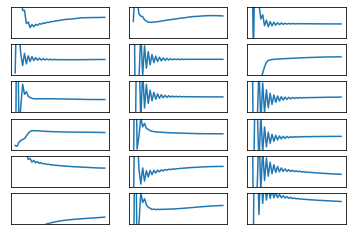


--

RMSProp zeros leaky_relu


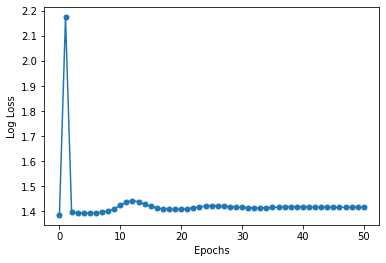

Training accuracy 0.2493
Validation accuracy 0.252


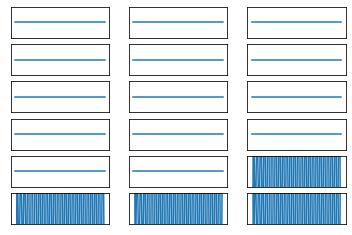


--

RMSProp random leaky_relu


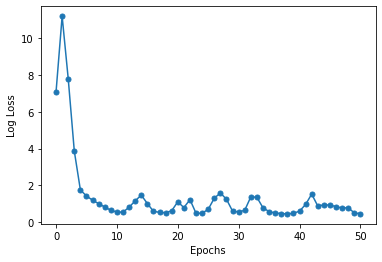

Training accuracy 0.8707
Validation accuracy 0.884


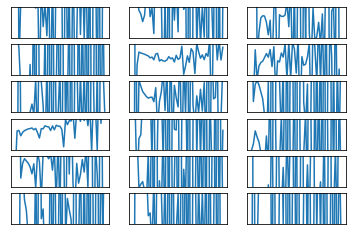


--

RMSProp xavier leaky_relu


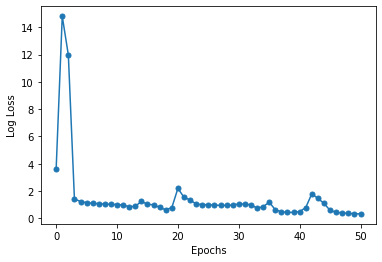

Training accuracy 0.9107
Validation accuracy 0.92


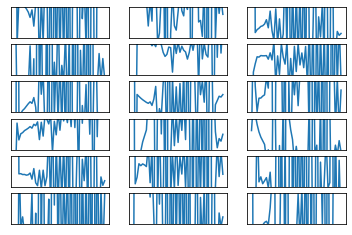


--

RMSProp he leaky_relu


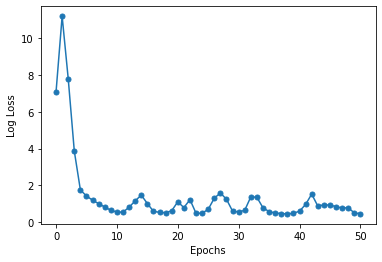

Training accuracy 0.8707
Validation accuracy 0.884


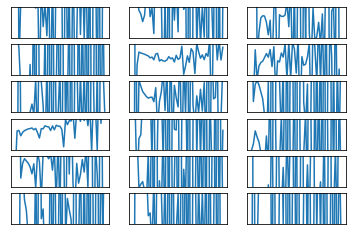


--

Adam zeros leaky_relu


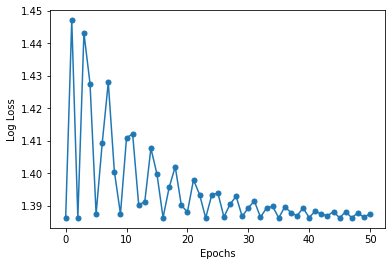

Training accuracy 0.2493
Validation accuracy 0.252


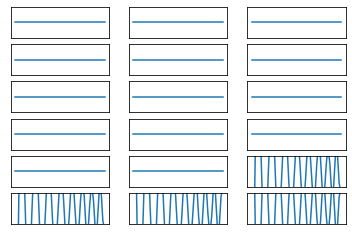


--

Adam random leaky_relu


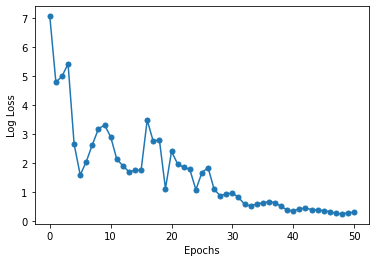

Training accuracy 0.8787
Validation accuracy 0.876


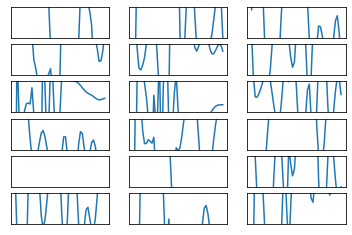


--

Adam xavier leaky_relu


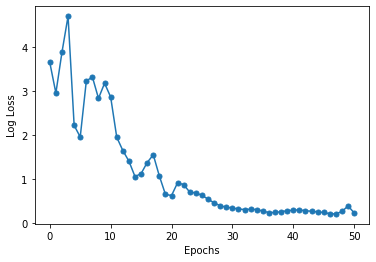

Training accuracy 0.908
Validation accuracy 0.924


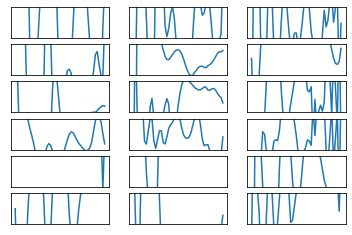


--

Adam he leaky_relu


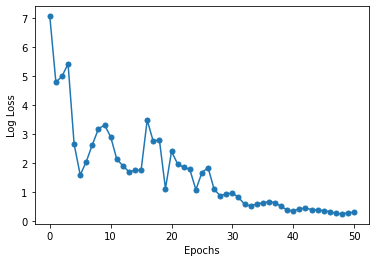

Training accuracy 0.8787
Validation accuracy 0.876


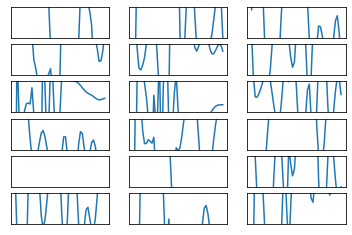


--



In [21]:
for algo in ['Momentum', 'NAG', 'AdaGrad', 'RMSProp', 'Adam']:
  for init_method in ['zeros', 'random', 'xavier', 'he']:
    for activation_function in ['leaky_relu']:
      print(algo, init_method, activation_function)
      model = FFNetwork(init_method=init_method, activation_function=activation_function, leaky_slope=0.1)
      model.fit(X_train, y_OH_train, epochs=50, eta=0.5, algo=algo, display_loss=True)
      post_process(plot_scale=0.05)
      print('\n--\n')